<a href="https://colab.research.google.com/github/vamsijan/audio_ravdess/blob/main/ABSA_SEM2014_res.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import pandas as pd

df1 = pd.read_csv('/content/Restaurants_Train_v2.csv', encoding='utf8')
df1.head()

,id,text,Aspect Term,polarity,from,to
0,3,The staff isn't the friendliest or most compet...,staff,negative,4,9
1,3,The staff isn't the friendliest or most compet...,service,negative,73,80
2,4,"Great for groups, great for a date, great for ...",brunch,positive,52,58
3,4,"Great for groups, great for a date, great for ...",nightcap,positive,64,72
4,7,"I like Cafe Noir dont get me wrong, it is jsut...",people,negative,56,62


In [6]:
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from sklearn.model_selection import train_test_split
from transformers import TFRobertaForSequenceClassification, RobertaTokenizer, PreTrainedModel, PreTrainedTokenizer
import re
#import emoji
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
#from transformers import TFGPT2LMHeadModel, GPT2Tokenizer, GPT2Config
import tensorflow as tf
from transformers import XLNetTokenizer, TFXLNetModel#
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score
import nltk
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [8]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # remove punctuation and special characters
    text = re.sub(r'[^\w\s]', '', text)
    # convert to lowercase
    text = text.lower()
    # tokenize text
    tokens = nltk.word_tokenize(text)
    # remove stop words
    tokens = [token for token in tokens if token not in stop_words]
    # lemmatize text
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    # join tokens back into text
    text = ' '.join(tokens)
    return text

df1['clean_text'] = df1['text'].apply(preprocess_text)
#Delete the useless Columns
df1 = df1.drop(["Aspect Term", "from", "to"], axis=1)

## Delete the polarity than contains CONFLICT, Means that the sentence contains more than one sentiment when it comes to the aspect term
df1.drop(df1[df1.polarity == 'conflict'].index, inplace = True)

df1['polarity'].unique()

array(['negative', 'positive', 'neutral'], dtype=object)

In [9]:
from transformers import RobertaTokenizer, TFRobertaModel

# split data into input and target variables
X = df1['clean_text'].values
y = pd.get_dummies(df1['polarity']).values

# Calculate the maximum sequence length from the input data
max_length = max([len(x.split()) for x in X])
print(f"Max length: {max_length}")

# split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# create Roberta tokenizer and encode inputs
tokenizer = RobertaTokenizer.from_pretrained('cardiffnlp/twitter-roberta-base')
train_encodings = tokenizer(X_train.tolist(), max_length=max_length, padding=True, truncation=True, return_tensors='np')
val_encodings = tokenizer(X_val.tolist(), max_length=max_length, padding=True, truncation=True, return_tensors='np')

# define early stopping and model checkpoint
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model_res_2015.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    {'input_sentence': train_encodings['input_ids'], 'input_mask': train_encodings['attention_mask']},
    y_train
)).batch(32).prefetch(1)

val_dataset = tf.data.Dataset.from_tensor_slices((
    {'input_sentence': val_encodings['input_ids'], 'input_mask': val_encodings['attention_mask']},
    y_val
)).batch(32).prefetch(1)

# define input layer with correct name and shape
inputs = {
    'input_sentence': tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='input_sentence'),
    'input_mask': tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='input_mask')
}

# define model architecture
roberta_model = TFRobertaModel.from_pretrained('cardiffnlp/twitter-roberta-base')
roberta_embeddings = roberta_model({'input_ids': inputs['input_sentence'], 'attention_mask': inputs['input_mask']})[0]
roberta_embeddings = tf.keras.layers.Dropout(0.2)(roberta_embeddings)
gru_output = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=False))(roberta_embeddings)
gru_output = tf.keras.layers.Dropout(0.2)(gru_output)
attention_output = tf.keras.layers.Attention()([gru_output, gru_output])
output = tf.keras.layers.Dense(3, activation='softmax')(attention_output)
model_ro_res_2015 = tf.keras.models.Model(inputs=inputs, outputs=output)
model_ro_res_2015.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# train model with early stopping and model checkpoint
history = model_ro_res_2015.fit(train_dataset, epochs=50, validation_data=val_dataset, callbacks=[early_stopping, model_checkpoint])

Max length: 34


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/499M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFRobertaModel.

All the layers of TFRobertaModel were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Epoch 1/50


91/91 [==============================] - ETA: 0s - loss: 0.8741 - accuracy: 0.6237 
Epoch 1: val_accuracy improved from -inf to 0.69348, saving model to best_model_res_2015.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


91/91 [==============================] - 1355s 14s/step - loss: 0.8741 - accuracy: 0.6237 - val_loss: 0.8717 - val_accuracy: 0.6935
Epoch 2/50
91/91 [==============================] - ETA: 0s - loss: 0.6705 - accuracy: 0.7258 
Epoch 2: val_accuracy improved from 0.69348 to 0.72399, saving model to best_model_res_2015.h5
91/91 [==============================] - 1297s 14s/step - loss: 0.6705 - accuracy: 0.7258 - val_loss: 0.7738 - val_accuracy: 0.7240
Epoch 3/50
91/91 [==============================] - ETA: 0s - loss: 0.5409 - accuracy: 0.7831 
Epoch 3: val_accuracy improved from 0.72399 to 0.74619, saving model to best_model_res_2015.h5
91/91 [==============================] - 1294s 14s/step - loss: 0.5409 - accuracy: 0.7831 - val_loss: 0.7529 - val_accuracy: 0.7462
Epoch 4/50
91/91 [==============================] - ETA: 0s - loss: 0.4767 - accuracy: 0.8094 
Epoch 4: val_accuracy did not improve from 0.74619
91/91 [==============================] - 1287s 14s/step - loss: 0.4767 - accur

In [10]:
df1

,id,text,polarity,clean_text
0,3,The staff isn't the friendliest or most compet...,negative,staff isnt friendliest competent stickler serv...
1,3,The staff isn't the friendliest or most compet...,negative,staff isnt friendliest competent stickler serv...
2,4,"Great for groups, great for a date, great for ...",positive,great group great date great early brunch nigh...
3,4,"Great for groups, great for a date, great for ...",positive,great group great date great early brunch nigh...
4,7,"I like Cafe Noir dont get me wrong, it is jsut...",negative,like cafe noir dont get wrong jsut people work...
...,...,...,...,...
3688,3703,They used shredded cheese on top!,neutral,used shredded cheese top
3689,3707,Best Pastrami I ever had and great portion wit...,positive,best pastrami ever great portion without ridic...
3690,3707,Best Pastrami I ever had and great portion wit...,positive,best pastrami ever great portion without ridic...
3691,3709,My wife had the fried shrimp which are huge an...,positive,wife fried shrimp huge loved


In [11]:
from sklearn.preprocessing import LabelBinarizer
# evaluate model
y_pred = model_ro_res_2015.predict(val_dataset)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)
f1 = f1_score(y_true, y_pred, average='weighted')

# Convert y_true and y_pred to one-hot encoded format
lb = LabelBinarizer()
y_true_one_hot = lb.fit_transform(y_true)
y_pred_one_hot = lb.transform(y_pred)

auc = roc_auc_score(y_true_one_hot, y_pred_one_hot, average='weighted', multi_class='ovr')
print('F1 score:', f1)
print('AUC-ROC score:', auc)

23/23 [==============================] - 86s 4s/step
F1 score: 0.7259299442038836
AUC-ROC score: 0.7589536616707737


23/23 [==============================] - 97s 4s/step
AUC-ROC scores: [0.86517877 0.78491646 0.86611225]


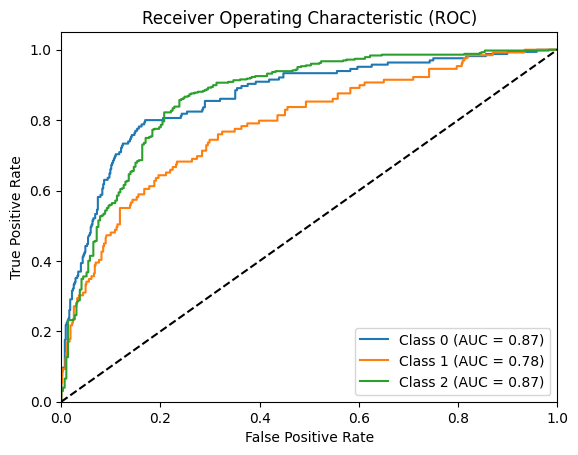

In [12]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

# Predict probabilities for validation set
y_pred_proba = model_ro_res_2015.predict(val_dataset)

# Calculate AUC-ROC scores
auc_roc_scores = roc_auc_score(y_val, y_pred_proba, average=None, multi_class='ovr')
print('AUC-ROC scores:', auc_roc_scores)

# Plot AUC-ROC curves for each class
n_classes = y_val.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()